In [1]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv
from feems import Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Data

Read sparse grid which EEMS was run on:

In [3]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "../data/grids/grid_200.shp" # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 40.36it/s]


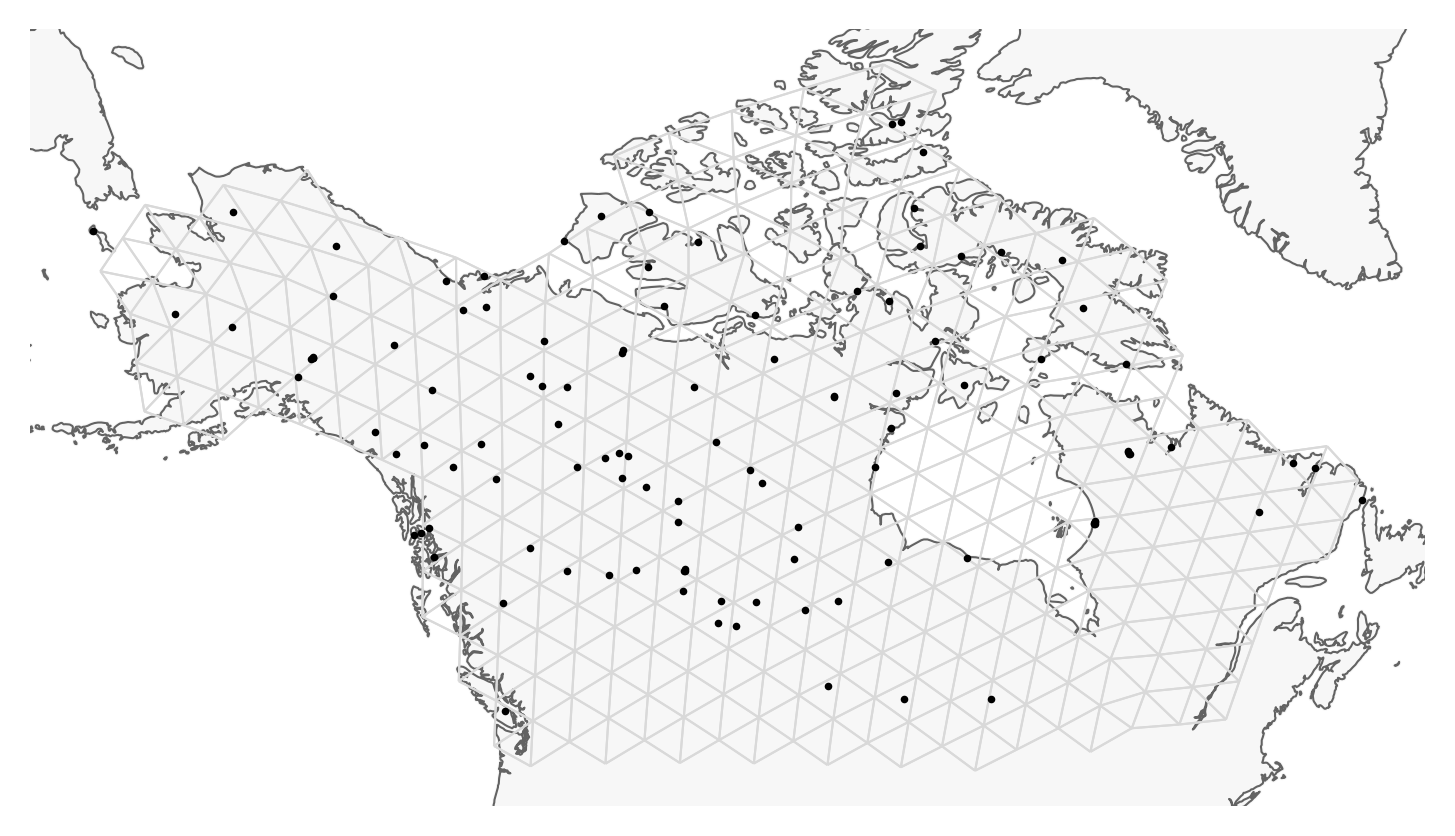

In [11]:
# setup figure
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
fig = plt.figure(dpi=300)

# axis 00
ax = fig.add_subplot(1, 1, 1, projection=projection)
v = Viz(ax, sp_graph, projection=projection, edge_width=0.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=7, 
        obs_node_size=3.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=False)
v.draw_samples()

# Fit

In [12]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=sp_graph.n_observed_nodes, factr=1e8)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1
 fold= 20
iteration lambda=20/20 alpha=1/1
 fold= 21
iteration lambda=20/20 alpha=1/1
 fold= 22
iteration lambda=20/20 alpha=1/1
 fold= 23
iteration 

2.06913808111479


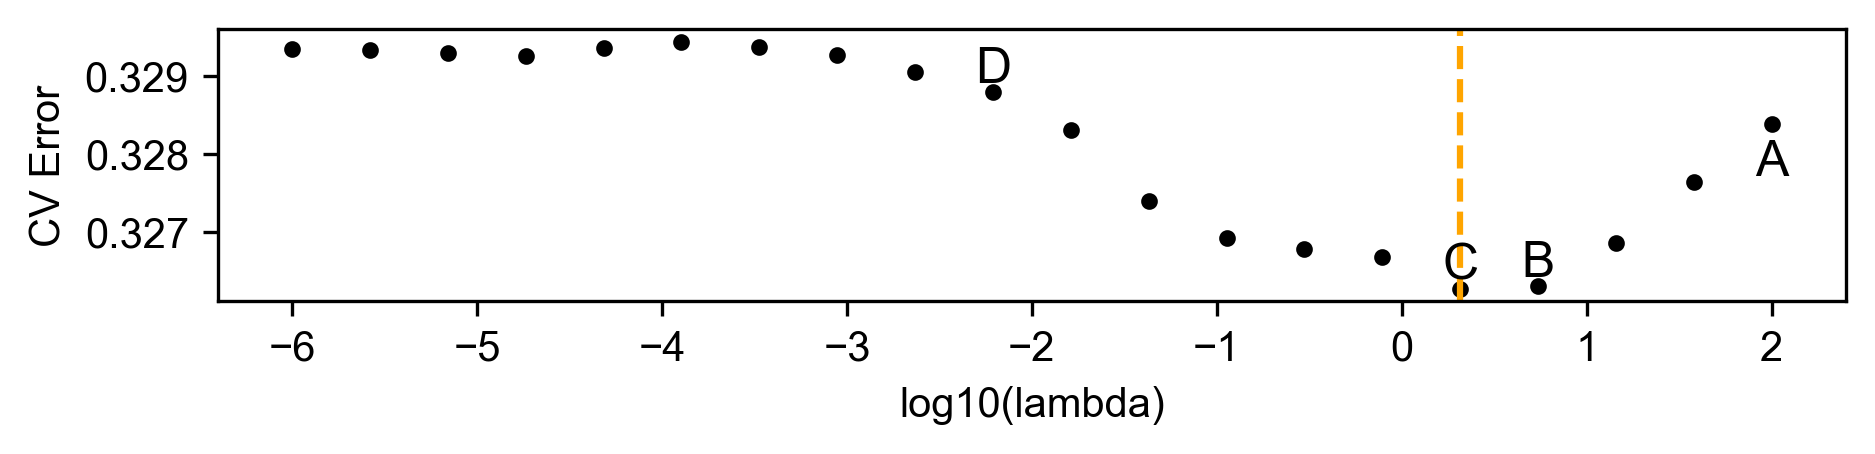

In [14]:
fig, ax = plt.subplots(dpi=300, figsize=(7, 1.2))
ax.plot(np.log10(lamb_grid), mean_cv_err, ".", color="black");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange", linestyle="dashed")
ax.text(np.log10(lamb_grid[0]), mean_cv_err[0, 0] - .0002, "A", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "top"})
ax.text(np.log10(lamb_grid[3]), mean_cv_err[3, 0], "B", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "bottom"})
ax.text(np.log10(lamb_cv), mean_cv_err[np.argmin(mean_cv_err), 0], "C", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "bottom"})
ax.text(np.log10(lamb_grid[10]), mean_cv_err[10, 0], "D", fontdict={"fontsize": 12, "horizontalalignment": "center", "verticalalignment": "bottom"})

print(lamb_cv)

constant-w/variance fit, converged in 139 iterations, train_loss=2154889.3098202
lambda=2.0691381, alpha=0.8385403, converged in 50 iterations, train_loss=2123876.8108183
CPU times: user 1.16 s, sys: 0 ns, total: 1.16 s
Wall time: 1.23 s


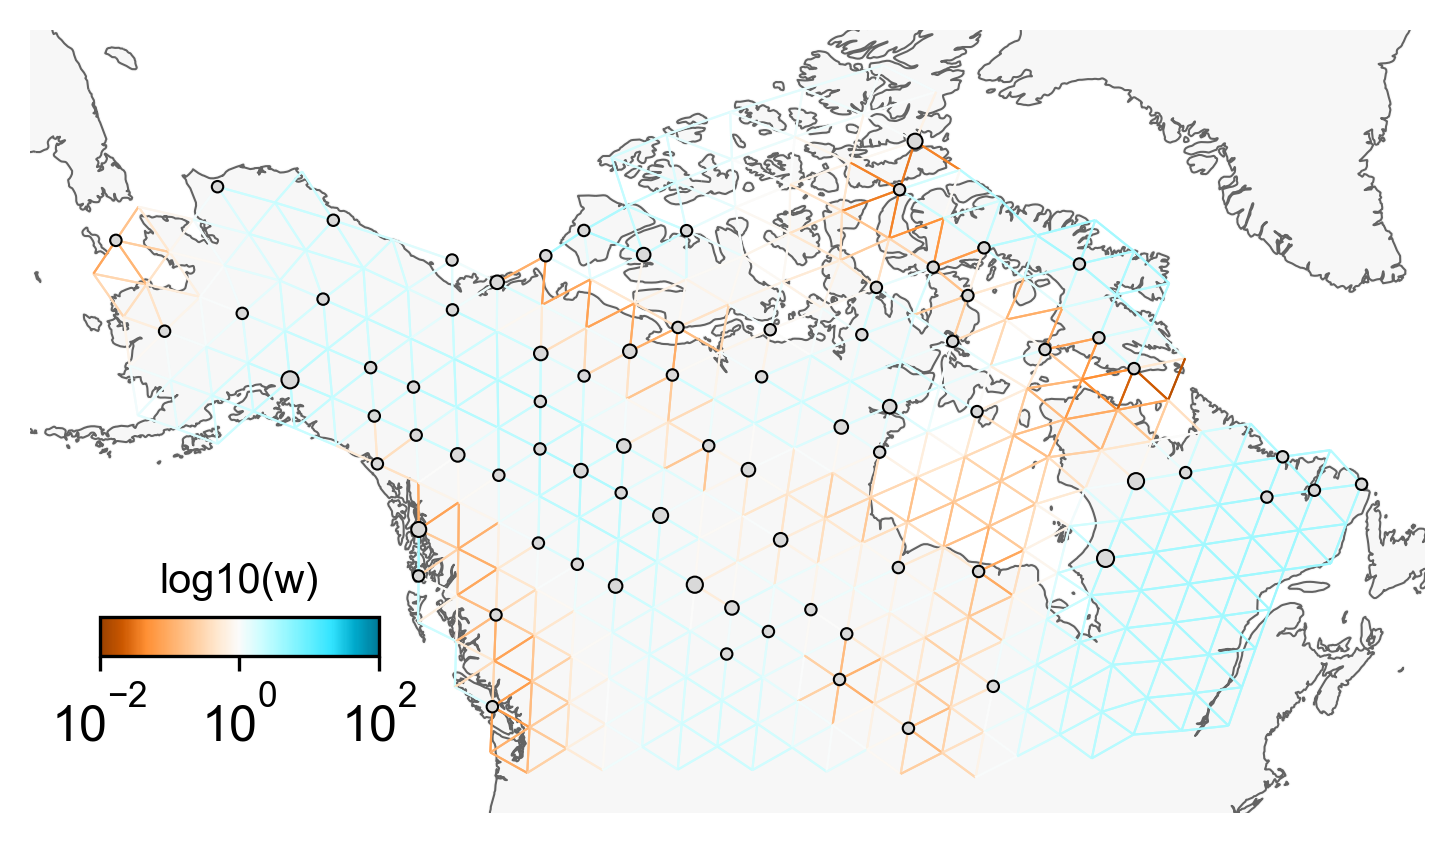

In [20]:
%%time
# re-fit
sp_graph.fit(lamb_cv)

# plot
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

# Table

| Method      | Sparse Grid (run-time) | Dense Grid (run-time)
| ----------- | ---------------------- | ---------------------
| EEMS        | 27.43hrs               | N/A                 |
| FEEMS (CV)  | 10min                  | 1.03hrs             |  
| FEEMS (min CV) | 1.23 sec            | 4.08 s              | 